In [1]:
import pandas as pd
import os
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from IPython.display import display_html
import warnings
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

from sklearn.utils import validation as skval
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # default='warn'

/Users/timothyteh/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
%%time
books_metadata = pd.read_json('./datasets/goodreads_books_poetry.json', lines=True)
interactions = pd.read_json('./datasets/goodreads_interactions_poetry.json', lines=True)

CPU times: user 44 s, sys: 41 s, total: 1min 25s
Wall time: 1min 54s


### EDA for Books Metadata

In [3]:
books_metadata.columns.values

array(['isbn', 'text_reviews_count', 'series', 'country_code',
       'language_code', 'popular_shelves', 'asin', 'is_ebook',
       'average_rating', 'kindle_asin', 'similar_books', 'description',
       'format', 'link', 'authors', 'publisher', 'num_pages',
       'publication_day', 'isbn13', 'publication_month',
       'edition_information', 'publication_year', 'url', 'image_url',
       'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'], dtype=object)

In [4]:
books_metadata.sample(2)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
5532,0374528616,23,[],US,eng,"[{'count': '809', 'name': 'to-read'}, {'count'...",,false,4.29,,...,3,,2003,https://www.goodreads.com/book/show/341089.Wit...,https://s.gr-assets.com/assets/nophoto/book/11...,341089,376,331461,Without End: New and Selected Poems,Without End: New and Selected Poems
19755,1770494073,9,[],US,,"[{'count': '417', 'name': 'to-read'}, {'count'...",,false,4.06,B004TQJKEI,...,10,,2012,https://www.goodreads.com/book/show/13414892-t...,https://images.gr-assets.com/books/1333581133m...,13414892,32,813571,The Hunting of the Snark: An Agony in Eight Fits,The Hunting of the Snark: An Agony in Eight Fits


In [5]:
books_metadata.shape

(36514, 29)

### Data Preprocessing for Books Metadata

In [6]:
# Limit the books metadata to selected fields
books_metadata_selected = books_metadata[['book_id', 'average_rating', 'is_ebook', 'num_pages', 
                                          'publication_year', 'ratings_count', 'language_code']]
books_metadata_selected.sample(10)

,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
24762,23505072,4.40,false,122,2014,4,
31281,18679991,3.92,false,126,2013,91,ind
13796,15816125,4.38,false,38,2012,111,en-US
4461,10205107,3.74,false,24,2012,19,
8475,3074240,4.00,false,,,4,
22825,32993317,4.13,false,272,2016,2,ind
22452,34443109,4.92,false,,2017,13,eng
16608,10697498,3.67,false,686,2004,6,por
2861,2243685,4.33,false,72,2007,36,
22595,10493950,4.21,false,32,2011,29,en-US


In [7]:
### Preprocessing of Books_Metadata

# replace blank cells with NaN
books_metadata_selected.replace('', np.nan, inplace=True)

# replace nan values in 'num_pages' to -1
books_metadata_selected['num_pages'].replace(np.nan, -1, inplace=True)

# convert values in 'num_pages' to numeric values
books_metadata_selected['num_pages'] = pd.to_numeric(books_metadata_selected['num_pages'])

# using pandas cut method to convert fields into discrete intervals
books_metadata_selected['num_pages'] = pd.cut(books_metadata_selected['num_pages'], bins=25)

# rounding ratings to neares .5 score
books_metadata_selected['average_rating'] = books_metadata_selected['average_rating'].apply(lambda x: round(x*2)/2)

# using pandas qcut method to convert fields into quantile-based discrete intervals
books_metadata_selected['ratings_count'] = pd.qcut(books_metadata_selected['ratings_count'], 25)

# replacing missing values to year 2100
books_metadata_selected['publication_year'].replace(np.nan, 2100, inplace=True)

# replacing missing values to 'unknown'
books_metadata_selected['language_code'].replace(np.nan, 'unknown', inplace=True)

# convert is_ebook column into 1/0 where true=1 and false=0
books_metadata_selected['is_ebook'] = books_metadata_selected.is_ebook.map(lambda x: 1.0*(x == 'true'))

# keep only english books
books_metadata_selected = books_metadata_selected.loc[books_metadata_selected['language_code'] == 'eng']

# print results
books_metadata_selected.sample(10)

,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
19591,6072732,4.0,0.0,"(-11.961, 437.44]",2004,"(4.0, 5.0]",eng
21789,13012720,4.0,0.0,"(-11.961, 437.44]",2011,"(34.0, 40.0]",eng
8285,15739194,3.0,0.0,"(-11.961, 437.44]",1962,"(18.0, 21.0]",eng
19777,25136346,4.5,1.0,"(-11.961, 437.44]",2100,"(-0.001, 2.0]",eng
7560,8716408,4.5,0.0,"(-11.961, 437.44]",2010,"(49.0, 59.0]",eng
15872,3151893,4.5,0.0,"(-11.961, 437.44]",1967,"(125.0, 179.0]",eng
26235,2262521,3.5,0.0,"(-11.961, 437.44]",2006,"(614.0, 1029527.0]",eng
6599,29491487,4.5,0.0,"(-11.961, 437.44]",2016,"(125.0, 179.0]",eng
7899,30842377,3.5,0.0,"(-11.961, 437.44]",2017,"(25.0, 29.0]",eng
14449,1035695,4.0,0.0,"(-11.961, 437.44]",2100,"(59.0, 73.0]",eng


In [8]:
books_metadata_selected.shape

(8393, 7)

### EDA for Interactions data

In [9]:
interactions.columns.values

array(['user_id', 'book_id', 'review_id', 'is_read', 'rating',
       'review_text_incomplete', 'date_added', 'date_updated', 'read_at',
       'started_at'], dtype=object)

In [10]:
interactions.sample(5)

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
718166,aaf5c8fcf9b86b77e32fe0e9dd00c27a,3280282,8e27c433fa4962eb76ec2db78050986c,False,0,,Thu Aug 07 15:13:37 -0700 2014,Thu Aug 07 15:13:37 -0700 2014,,
471327,a06e4e92867588d660fc448301f3bc70,1281407,80b0b702222a80b2b532d836ddb87f9f,True,5,,Wed Jun 24 06:34:30 -0700 2009,Wed Jun 24 06:34:46 -0700 2009,,
2141069,d9934e33e84dd1275861d5e6eac92766,6295,bcef81312b0e1891123382ace0ee4fef,True,5,,Thu Jun 01 10:45:53 -0700 2017,Thu Jun 01 10:45:53 -0700 2017,,
2433819,ae9364517b03eb207bc8e16278e51c84,211515,1786d4f8c8576e78448457095fb71a85,True,5,,Mon Nov 23 15:44:54 -0800 2015,Mon Nov 23 15:44:54 -0800 2015,,
2183010,45d66351df8df90daa8333a9bb5af7d7,1402088,090cfcc45a38314adf909b6a95d4f142,True,2,,Wed Aug 30 20:41:36 -0700 2017,Sun Sep 10 05:32:34 -0700 2017,,


In [11]:
interactions.shape

(2734350, 10)

### Data Preprocessing for Interactions data

In [12]:
# Limit the books metadata to selected fields
interactions_selected = interactions[['user_id', 'book_id', 'is_read', 'rating']]

# Limit the books to only those in the preprocessed books metadata
english_book_ids = list(books_metadata_selected['book_id'])
interactions_selected = interactions_selected.loc[interactions_selected['book_id'].isin(english_book_ids)]

# # mapping boolean to string
booleanDictionary = {True: 'true', False: 'false'}
interactions_selected['is_read'] = interactions_selected['is_read'].replace(booleanDictionary)

# # convert is_read column into 1/0 where true=1 and false=0
interactions_selected['is_read'] = interactions_selected.is_read.map(
    lambda x: 1.0*(x == 'true'))

interactions_selected

,user_id,book_id,is_read,rating
0,8842281e1d1347389f2ab93d60773d4d,1384,1.0,4
1,8842281e1d1347389f2ab93d60773d4d,1376,1.0,4
2,8842281e1d1347389f2ab93d60773d4d,30119,1.0,5
3,72fb0d0087d28c832f15776b0d936598,24769928,0.0,0
4,72fb0d0087d28c832f15776b0d936598,30119,1.0,3
...,...,...,...,...
2734321,bfc558b791304f0ce74ad1c3a6ab08f7,1381,1.0,5
2734322,e9aea57d21cdf9d91a65687d59518924,25144676,0.0,0
2734323,e9aea57d21cdf9d91a65687d59518924,25330489,0.0,0
2734339,148e49f7ed14137ff13a9a31c770487d,291,0.0,0


In [13]:
# how many data points are there where the user hasn't read the book but have given the ratings.
interactions_selected.groupby(['rating', 'is_read']).size().reset_index().pivot(columns='rating', index='is_read', values=0)

rating,0,1,2,3,4,5
is_read,,,,,,
0.0,685408.0,NaN,NaN,NaN,NaN,NaN
1.0,37226.0,9416.0,30095.0,118069.0,207232.0,265438.0


In [14]:
# drop interactions where is_read is false, and limit interactions from random 5000 users to limit the data size for further analysis
interactions_selected2 = interactions_selected.loc[interactions_selected['is_read']==1, ['user_id', 'book_id', 'rating']]

interactions_selected2 = interactions_selected2[interactions_selected2['user_id'].isin(random.sample(list(interactions_selected2['user_id'].unique()), 
                                                                                                  k=5000))]

interactions_selected2.sample(10)

,user_id,book_id,rating
421330,f1c25aac017a1c4d91f178e5967e8e74,5932,5
567263,1c469fc5673cd626f6ff2c460bec5d5e,30119,5
2301145,e60410d4c62e3bd2779859e6c8dc971d,23919,4
2337539,0cc53394ed77243ccc84335561b93265,5289,4
134337,cf222b895e4eb1259fc3c77f0fdee262,30119,5
986968,96912f242796338781fe1fdc0dc2f4f9,670257,5
779985,b7450d4404376112e947ae898a13a03d,1420,4
2387162,b27036b8f27f2bd93f2053012a06f61e,30119,4
1580485,c746950b8b2a660e3b64a5c447f2e2ce,847086,4
2168055,dce7310be87358bc280f383636199020,1381,5


In [15]:
interactions_selected2.shape

(14712, 3)

In [16]:
# computer average number of interactions per user
list_of_all_users_who_rated = list(interactions_selected2['user_id'])
interaction_dict = {}
for user in list_of_all_users_who_rated:
    if user not in interaction_dict.keys():
        interaction_dict[user] = 1
    else:
        interaction_dict[user] += 1
average_interactions_per_user = sum(interaction_dict.values()) / len(interaction_dict)
print("Average interactions per user: {}".format(average_interactions_per_user))

Average interactions per user: 2.9424


In [17]:
relevant_book_ids = interactions_selected2['book_id'].unique()
relevant_book_ids

array([   14706,    66414, 28645638, ..., 24443008, 13618568, 17204884])

### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Interactions data

In [18]:
user_book_interaction = pd.pivot_table(interactions_selected2, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)

user_book_interaction.head(10)

book_id,244,289,290,291,292,484,676,1371,1372,1376,...,35612585,35631002,35654589,35760350,35834374,36130073,36188318,36262212,36262245,36270857
user_id,,,,,,,,,,,,,,,,,,,,,
001b21034023a28a866d5b25fd1197dd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00214d8b0a020837cccf5f41eb563037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0023df1a516a32512133b5f734718f17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002c155f1f41ec3ff29fe539037e6d5b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00589e918b1823f0ff60b1126035017c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005c36da8dc4344302ac68cf945a69cc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006f960e46a63093bc708f1b7dafc26d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00b278de162dcde3f6cda38a6501b506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00c51596f015f70d15976b9a310be679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
len(user_book_interaction.index)

5000

In [20]:
user_book_interaction_csr = csr_matrix(user_book_interaction.values)

In [21]:
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

### Finding average number of interactions

In [71]:
from collections import defaultdict

user_num_interactions = defaultdict(int)

for index, row in user_book_interaction.iterrows():
    user_num_interactions[index] += (row > 0).sum()  # Count values greater than 0 in the row

average_num_interactions = sum(user_num_interactions.values()) / len(user_num_interactions)
print("Average number of interactions in normal warm-start scenario (goodreads): ", average_num_interactions)

Average number of interactions in normal warm-start scenario (goodreads):  2.7784


### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Books Metadata

In [22]:
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
    
relevant_item_dict = {}
for i in relevant_book_ids:
    relevant_item_dict[i] = item_dict[i]


In [23]:
# dummify categorical features
books_metadata_selected_transformed = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 'num_pages', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])

books_metadata_selected_transformed = books_metadata_selected_transformed.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed = books_metadata_selected_transformed.loc[books_metadata_selected_transformed["book_id"].isin(relevant_item_dict)].set_index("book_id")
# books_metadata_selected_transformed = books_metadata_selected_transformed.transpose()
books_metadata_selected_transformed.head(5)

,average_rating_0.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,is_ebook_0.0,...,"ratings_count_(40.0, 49.0]","ratings_count_(49.0, 59.0]","ratings_count_(59.0, 73.0]","ratings_count_(73.0, 94.0]","ratings_count_(94.0, 125.0]","ratings_count_(125.0, 179.0]","ratings_count_(179.0, 285.0]","ratings_count_(285.0, 614.0]","ratings_count_(614.0, 1029527.0]",language_code_eng
book_id,,,,,,,,,,,,,,,,,,,,,
244,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
289,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
290,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
291,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
292,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1


In [24]:
books_metadata_selected_transformed.shape

(2149, 211)

In [25]:
# convert to csr matrix
# books_metadata_csr = csr_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_csr = csr_matrix(books_metadata_selected_transformed.values)
books_metadata_csr

<2149x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 12894 stored elements in Compressed Sparse Row format>

In [26]:
# books_metadata_coo = coo_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_coo = coo_matrix(books_metadata_selected_transformed.values)
books_metadata_coo

<2149x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 12894 stored elements in COOrdinate format>

### Hyperparameter Tuning

In [27]:
train_interactions, test_interactions = random_train_test_split(user_book_interaction_csr, test_percentage=0.2)
train_interactions

<5000x2149 sparse matrix of type '<class 'numpy.float64'>'
	with 11113 stored elements in COOrdinate format>

In [28]:
test_interactions

<5000x2149 sparse matrix of type '<class 'numpy.float64'>'
	with 2779 stored elements in COOrdinate format>

In [29]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [30]:
num_samples_for_random_search = 10

In [31]:
def random_search_auc(train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = auc_score(model, validation, train_interactions=train2, item_features = item_features, num_threads=num_threads).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)

In [32]:
### Best hyperparameters to maximise AUC score
(score_auc, hyperparams_auc, model) = max(random_search_auc(train=train_interactions, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])

print("Best AUC score {} \nHyperparameters: \n{}".format(score_auc, hyperparams_auc))

Best AUC score 0.8810311555862427 
Hyperparameters: 
{'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.019728507178583092, 'item_alpha': 7.765790549013491e-09, 'user_alpha': 2.6795642020033936e-08, 'max_sampled': 9, 'num_epochs': 6}


In [33]:
train2, validation = random_train_test_split(train_interactions, test_percentage=0.2)
train2

<5000x2149 sparse matrix of type '<class 'numpy.float64'>'
	with 8890 stored elements in COOrdinate format>

In [34]:
validation

<5000x2149 sparse matrix of type '<class 'numpy.float64'>'
	with 2223 stored elements in COOrdinate format>

In [35]:
def random_search_precision_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = precision_at_k(model, validation, train2, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best precision score at k=1000: 0.0012649372220039368
Precision scores at k=1000: [0.0013056457, 0.0007167424, 0.00048085663, 0.00036064244, 0.00028851393]

Best precision score at k=2000: 0.0006981057813391089
Precision scores at k=2000: [0.0013017522, 0.00071641797, 0.00048085663, 0.00036064244, 0.00028851393]

Best precision score at k=3000: 0.00046121919876895845
Precision scores at k=3000: [0.0012809865, 0.0007154445, 0.00048085663, 0.00036064244, 0.00028851393]

Best precision score at k=4000: 0.00034699455136433244
Precision scores at k=4000: [0.001046723, 0.00068299804, 0.00048085663, 0.00036064244, 0.00028851393]

Best precision score at k=5000: 0.0002799999783746898
Precision scores at k=5000: [0.0013114861, 0.0007141467, 0.00048085663, 0.00036064244, 0.00028851393]

Best highest average precision: 0.0006311291654128581 
Best k: 5000 
Best hyperparams to maximise precision_at_k score: {'no_components': 23, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 

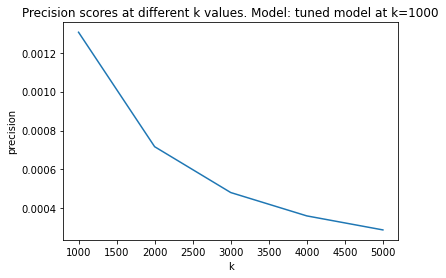

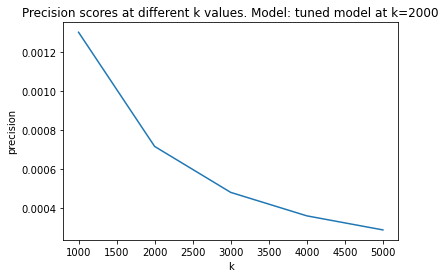

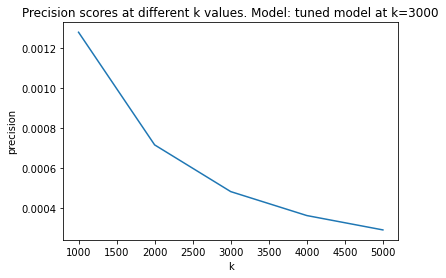

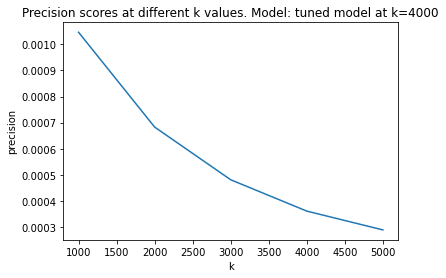

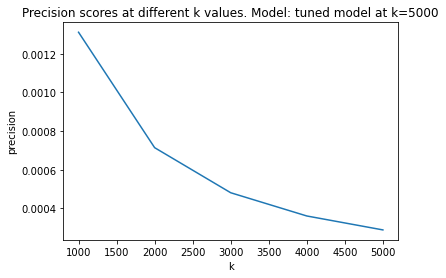

In [36]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 1: large k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1000, 5001, 1000):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1000, 5001, 1000):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1000, 5001,1000), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))


Best precision score at k=1: 0.042553190141916275
Precision scores at k=1: [0.050616484, 0.032446463, 0.022928836, 0.017845554, 0.014665802, 0.013086741, 0.014091036, 0.012735236, 0.011464418]

Best precision score at k=2: 0.025510204955935478
Precision scores at k=2: [0.0532122, 0.027255028, 0.019251568, 0.026443867, 0.021414666, 0.01838633, 0.016130527, 0.014682025, 0.013122791]

Best precision score at k=3: 0.032307691872119904
Precision scores at k=3: [0.09604153, 0.048020765, 0.032230154, 0.02790396, 0.022323167, 0.018710796, 0.016130527, 0.014195328, 0.012762276]

Best precision score at k=4: 0.027908805757761
Precision scores at k=4: [0.021414666, 0.054510057, 0.03634004, 0.027255028, 0.022323167, 0.01860264, 0.016779456, 0.01646658, 0.014781167]

Best precision score at k=5: 0.020156249403953552
Precision scores at k=5: [0.06229721, 0.031148605, 0.021847285, 0.025632706, 0.020895522, 0.018061865, 0.01575971, 0.01395198, 0.0126180705]

Best precision score at k=6: 0.01729559712

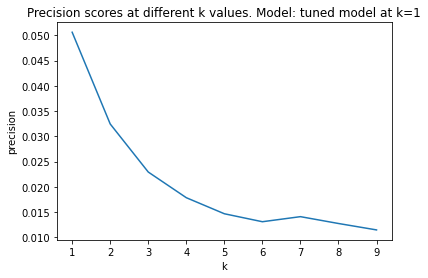

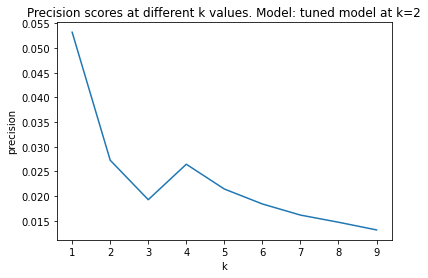

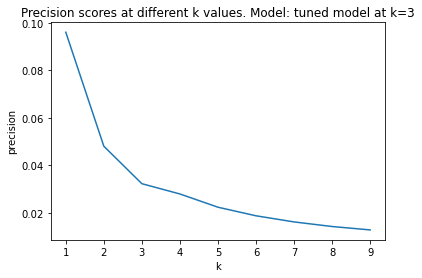

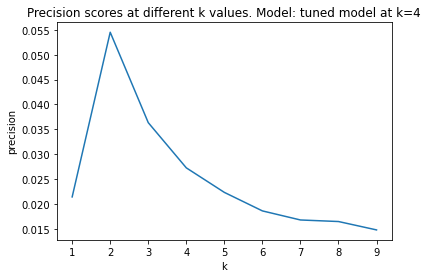

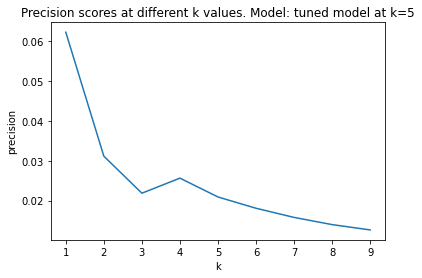

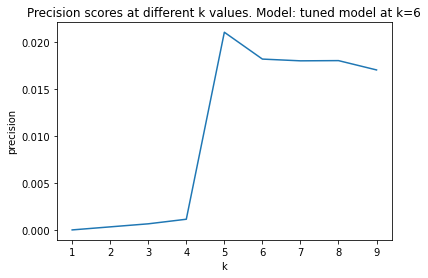

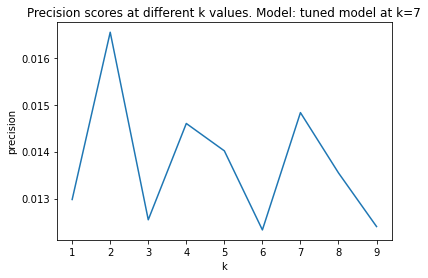

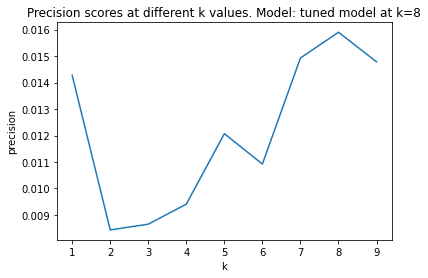

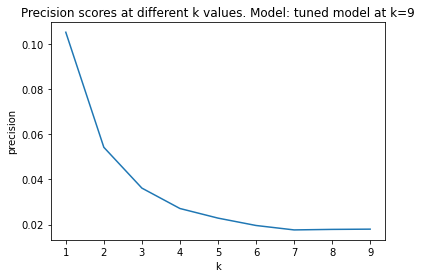

In [37]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 2: low k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1, 10):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1, 10):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1, 10), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))

In [38]:
def random_search_recall_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = recall_at_k(model, test_interactions, train_interactions, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best recall score at k=500: 0.8734009467591556
Recall scores at k=500: [0.8579102565372587, 0.9213452423953123, 0.9520752910238547, 0.9890173637740153, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1000: 0.9308758046817748
Recall scores at k=1000: [0.8448875172021454, 0.9190733086033472, 0.9558976270834599, 0.9912664936188622, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1500: 0.9642467593213861
Recall scores at k=1500: [0.818864848639602, 0.9153747370609286, 0.9641748462951373, 0.9941866753190569, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2000: 0.9927766171547265
Recall scores at k=2000: [0.8108848914708062, 0.9149577161001732, 0.9649887246876556, 0.9947004109885357, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2500: 1.0
Recall scores at k=2500: [0.5233660617041197, 0.7676355756754677, 0.8832461330010768, 0.9571217177803809, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=3000: 1.0
Recall scores at k=3000: [0.8002830902793332, 0.89645053630

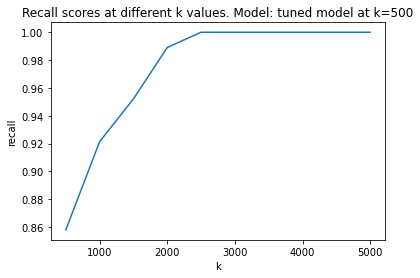

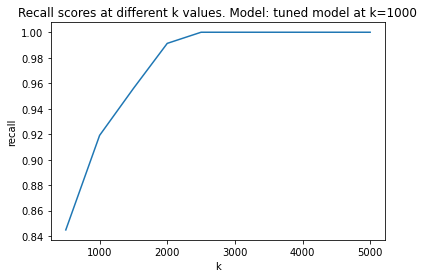

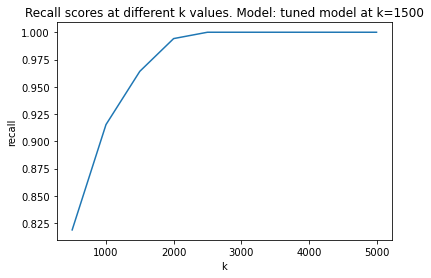

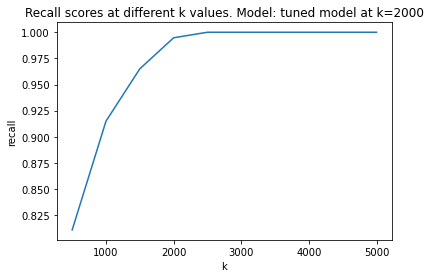

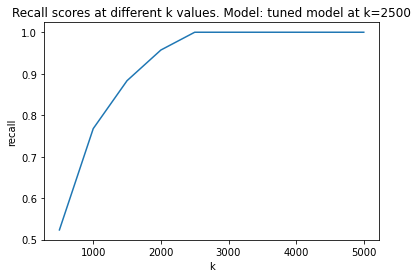

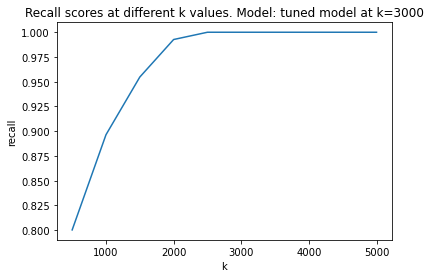

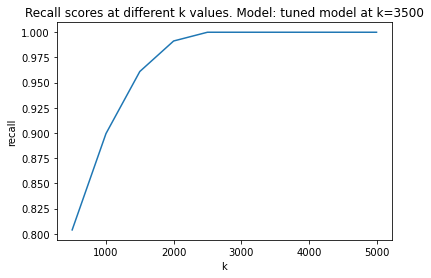

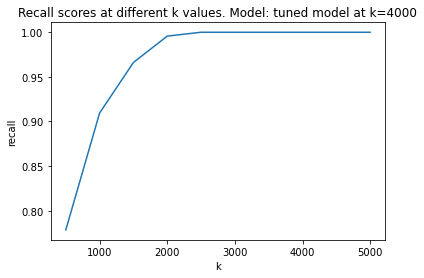

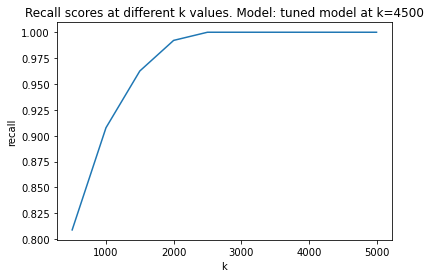

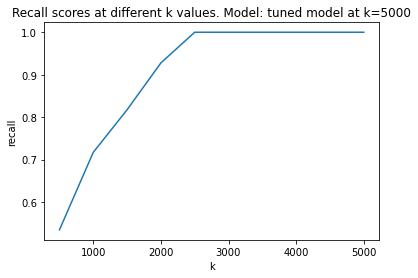

In [39]:
### Best hyperparameters to maximise recall_at_k score

counter = 1
best_average_score_recall = 0
best_hyperparams_recall = None
best_model_recall = None
for k in range(500, 5001, 500):
    (score_recall, hyperparams_recall, model) = max(random_search_recall_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest recall score at k={}: {}".format(k, score_recall))
    recall_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its recall score changes as k changes
    for j in range(500, 5001, 500):
        recall_score = recall_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        recall_score_array.append(recall_score)
    ave_recall_score = sum(recall_score_array) / len(recall_score_array)
    if ave_recall_score > best_average_score_recall:
        best_average_score_recall = ave_recall_score
        best_hyperparams_recall = hyperparams_recall
        best_model_recall = model
    print("Recall scores at k={}: {}".format(k, recall_score_array))
    plt.figure(counter)
    plt.plot(range(500, 5001, 500), recall_score_array)
    plt.xlabel('k')
    plt.ylabel('recall')
    plt.title("Recall scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average recall: {} \nBest hyperparams to maximise recall_at_k score: {}".format(best_average_score_recall, hyperparams_recall))

### Model Evaluation

In [40]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

# Normal Case

In [41]:
users = list(interactions_selected2['user_id'])
random_user = random.choice(users)

### 1. Model that maximises AUC score

In [42]:
AUC_score = auc_score(model, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
precision_k = precision_at_k(model, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(model, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(model, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.69631547 

Precision at k= 5 : 0.004643449 

Recall at k= 500 : 0.5320537487204153 

User: 289c4fe45dbade79dcdb32f5c6143841
Known Likes:
1- The Poetry of Robert Frost
2- Where the Sidewalk Ends
3- The Complete Stories and Poems
4- Hamlet

 Recommended Items:
1- Selected Poems
2- The Complete English Poems
3- Robert Browning's Poetry
4- Leaves of Grass
5- John Donne's Poetry
6- The Iliad
7- Orlando Furioso
8- The Odyssey
9- The Major Works
10- The Divine Comedy


### 2. Model that maximises precision_at_k score

In [43]:
AUC_score = auc_score(best_model_precision, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_precision, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_precision, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.86816305 

Precision at k= 5 : 0.027529022 

Recall at k= 500 : 0.8488530614401261 

User: 289c4fe45dbade79dcdb32f5c6143841
Known Likes:
1- The Poetry of Robert Frost
2- Where the Sidewalk Ends
3- The Complete Stories and Poems
4- Hamlet

 Recommended Items:
1- The Odyssey
2- Poetry and Prose
3- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
4- The Complete Sonnets and Poems
5- The Book of Disquiet
6- Leaves of Grass
7- John Donne's Poetry
8- Robert Browning's Poetry
9- The Canterbury Tales
10- The Portable Dorothy Parker


### 3. Model that maximises recall_at_k score

In [45]:
AUC_score = auc_score(best_model_recall, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_recall, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_recall, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_recall, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.8829521 

Precision at k= 5 : 0.010724157 

Recall at k= 500 : 0.8734009467591556 

User: 289c4fe45dbade79dcdb32f5c6143841
Known Likes:
1- The Poetry of Robert Frost
2- Where the Sidewalk Ends
3- The Complete Stories and Poems
4- Hamlet

 Recommended Items:
1- The Complete English Poems
2- Selected Poems
3- The Odyssey
4- Poetry and Prose
5- Leaves of Grass
6- Robert Browning's Poetry
7- John Donne's Poetry
8- The Canterbury Tales
9- The Book of Disquiet
10- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged


# Cold start scenario

In [46]:
interactions_selected1 = interactions_selected[interactions_selected['user_id'].isin(random.sample(list(interactions_selected['user_id'].unique()), 
                                                                                                  k=5000))]

user_book_interaction1 = pd.pivot_table(interactions_selected1, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
user_book_interaction1 = user_book_interaction1.fillna(0)

user_book_interaction1.head(10)

user_book_interaction1

book_id,289,290,291,292,484,676,1371,1372,1376,1381,...,35659309,35661045,35663570,35668923,35704999,35783117,35991559,36126998,36130073,36153320
user_id,,,,,,,,,,,,,,,,,,,,,
000a9539c044b397780166167b1327b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ae0bb745fd6791ed4394f83fea6e1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001324c05238f45e22ad6052a6cc21b5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004a6fc7b6c0ad588978efb7dac5ef32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00b80c893a0dbfab1a48dbbcb5f9f5f5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffec0cc0703df88728a3b90c44fb7d2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff38ca0fba47eb54c6b3d46b98b43f9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff3d798bbf27d42be50ce445fccbf49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
relevant_book_ids1 = interactions_selected1['book_id'].unique()
relevant_book_ids1

array([    2696,     1420,     1371, ...,  5702354, 33169254,  8381810])

In [48]:
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
    
relevant_item_dict = {}
for i in relevant_book_ids1:
    relevant_item_dict[i] = item_dict[i]

In [49]:
books_metadata_selected_transformed1 = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 'num_pages', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])

books_metadata_selected_transformed1 = books_metadata_selected_transformed1.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed1 = books_metadata_selected_transformed1.loc[books_metadata_selected_transformed1["book_id"].isin(relevant_item_dict)].set_index("book_id")
# books_metadata_selected_transformed = books_metadata_selected_transformed.transpose()
books_metadata_selected_transformed1.head(5)

,average_rating_0.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,is_ebook_0.0,...,"ratings_count_(40.0, 49.0]","ratings_count_(49.0, 59.0]","ratings_count_(59.0, 73.0]","ratings_count_(73.0, 94.0]","ratings_count_(94.0, 125.0]","ratings_count_(125.0, 179.0]","ratings_count_(179.0, 285.0]","ratings_count_(285.0, 614.0]","ratings_count_(614.0, 1029527.0]",language_code_eng
book_id,,,,,,,,,,,,,,,,,,,,,
289,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
290,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
291,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
292,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
484,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [50]:
books_metadata_selected_transformed1.shape

(3103, 211)

In [51]:
books_metadata_csr1 = csr_matrix(books_metadata_selected_transformed1.values)
books_metadata_csr1

<3103x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 18618 stored elements in Compressed Sparse Row format>

In [52]:
user_book_interaction_csr1 = csr_matrix(user_book_interaction1.values)

user_id = list(user_book_interaction1.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

print(len(user_dict))

5000


In [53]:
train_interactions, test_interactions = random_train_test_split(user_book_interaction_csr1, test_percentage=0.2)
train_interactions

<5000x3103 sparse matrix of type '<class 'numpy.float64'>'
	with 8424 stored elements in COOrdinate format>

In [54]:
train2, validation = random_train_test_split(train_interactions, test_percentage=0.2)
train2

<5000x3103 sparse matrix of type '<class 'numpy.float64'>'
	with 6739 stored elements in COOrdinate format>

In [55]:
users = list(interactions_selected1['user_id'])
print(len(users))

22031


In [56]:
def find_known_items_for_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr1))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    return known_items

In [57]:
### Find cold-start users
cold_start_users = []
for user in users:
    known_items = find_known_items_for_user(model, user_book_interaction1, user, user_dict, relevant_item_dict)
    if len(known_items) == 0:
        cold_start_users.append(user)

print(len(cold_start_users))

3979


In [58]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr1))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

### Hyperparameter Tuning

In [59]:
### Best hyperparameters to maximise AUC score
(score_auc, hyperparams_auc, model) = max(random_search_auc(train=train_interactions, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])

print("Best AUC score {} \nHyperparameters: \n{}".format(score_auc, hyperparams_auc))

Best AUC score 0.9067603945732117 
Hyperparameters: 
{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.021028532328655553, 'item_alpha': 3.0037065911818422e-09, 'user_alpha': 3.8922178626692175e-09, 'max_sampled': 8, 'num_epochs': 6}



Best precision score at k=1: 0.11752577126026154
Precision scores at k=1: [0.13911472, 0.06955736, 0.046371575, 0.03590786, 0.028906956, 0.024390245, 0.021164022, 0.018518519, 0.016460905]

Best precision score at k=2: 0.043887145817279816
Precision scores at k=2: [0.0009033424, 0.056458898, 0.037639268, 0.02868112, 0.029990967, 0.025444144, 0.023486901, 0.02201897, 0.022081705]

Best precision score at k=3: 0.019972452893853188
Precision scores at k=3: [0.028906956, 0.028003613, 0.020776875, 0.018292682, 0.01788618, 0.019120747, 0.017292554, 0.015582656, 0.015657933]

Best precision score at k=4: 0.016436902806162834
Precision scores at k=4: [0.040650405, 0.03026197, 0.022884674, 0.018518519, 0.016440831, 0.017012948, 0.015485869, 0.014227643, 0.013349392]

Best precision score at k=5: 0.020930234342813492
Precision scores at k=5: [0.0009033424, 0.040650405, 0.027100272, 0.02145438, 0.029810298, 0.025444144, 0.023486901, 0.022131888, 0.022081705]

Best precision score at k=6: 0.01691

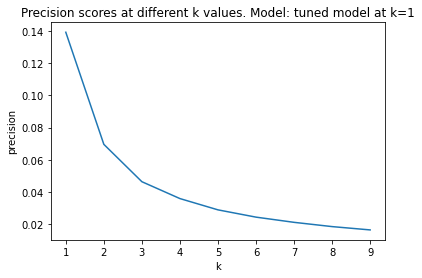

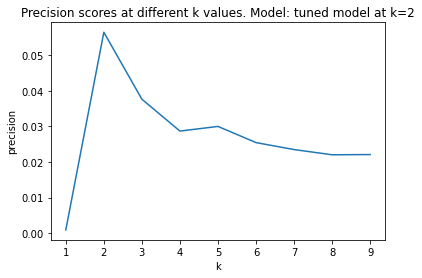

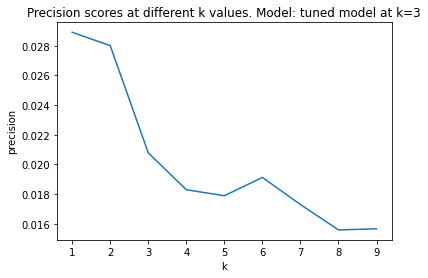

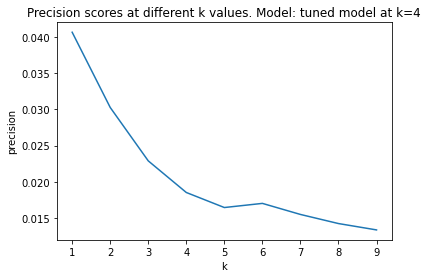

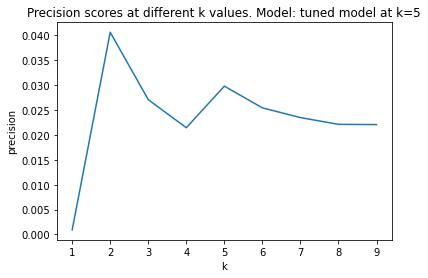

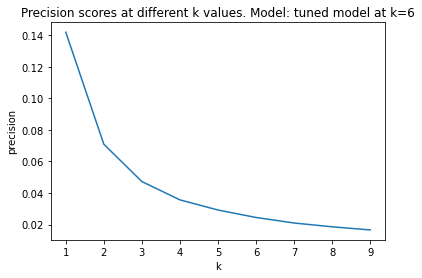

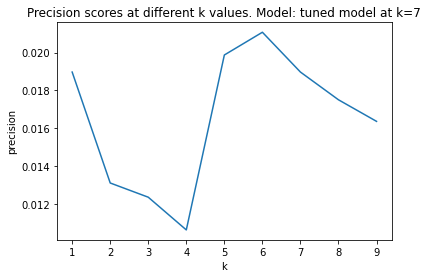

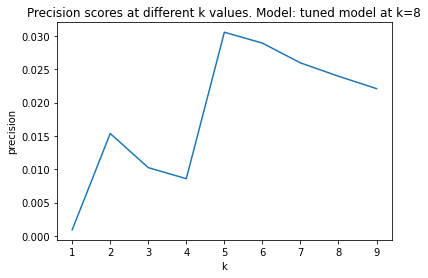

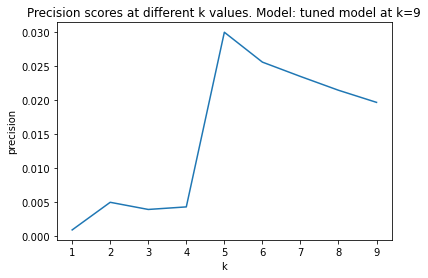

In [60]:
### Best hyperparameters to maximise precision_at_k score

counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1, 10):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1, 10):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1, 10), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))


Best recall score at k=500: 0.8644117071483176
Recall scores at k=500: [0.8507151460403493, 0.9163902869187422, 0.9412809538148291, 0.9655439411536972, 0.985935461206464, 0.9996988858777477, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1000: 0.9275206217520964
Recall scores at k=1000: [0.850072769246211, 0.913639035861258, 0.9455657360806413, 0.9691211052322163, 0.9837473652514301, 0.999096657633243, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1500: 0.9566460135609072
Recall scores at k=1500: [0.8548092226954016, 0.9178044478857486, 0.949403507262586, 0.9665666537617759, 0.9891975308641974, 0.999096657633243, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2000: 0.9748120907787086
Recall scores at k=2000: [0.8043819274171577, 0.904460073701266, 0.9408830530104243, 0.9669494988600679, 0.9871714629844711, 0.9965371875940983, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2500: 0.9901339428485431
Recall scores at k=2500: [0.8085193788445821, 0.8915899542593309, 0.9378769303566052, 0.969339054501

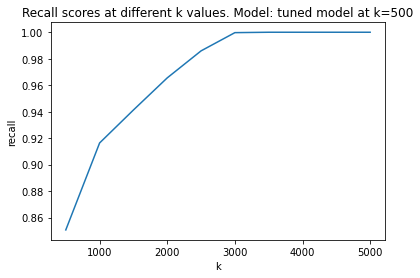

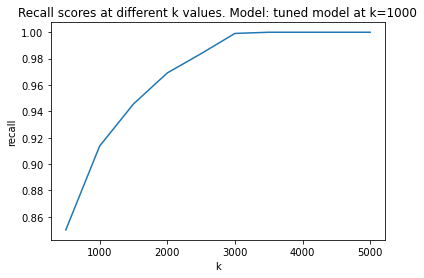

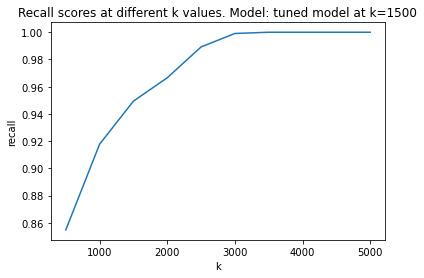

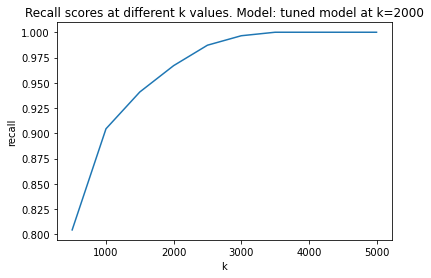

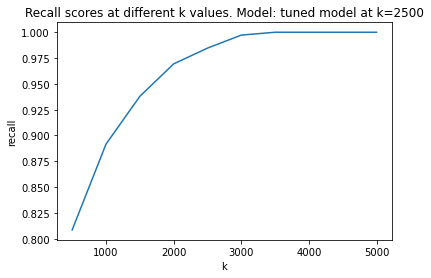

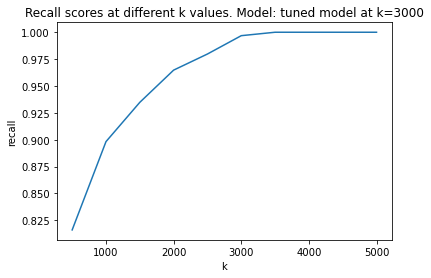

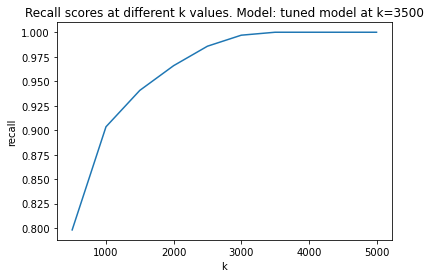

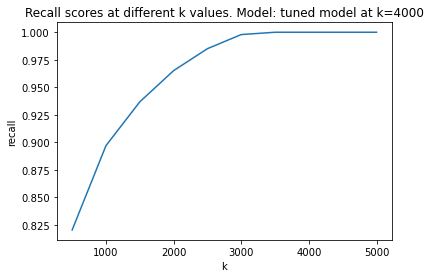

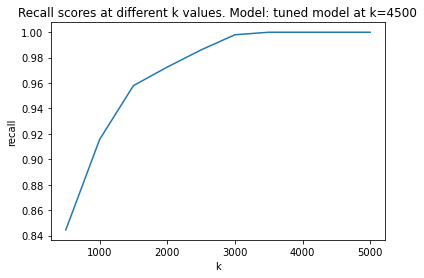

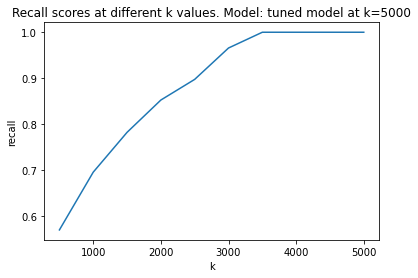

In [61]:
### Best hyperparameters to maximise recall_at_k score

counter = 1
best_average_score_recall = 0
best_hyperparams_recall = None
best_model_recall = None
for k in range(500, 5001, 500):
    (score_recall, hyperparams_recall, model) = max(random_search_recall_at_k(k=k, train=train2, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])
    print("\nBest recall score at k={}: {}".format(k, score_recall))
    recall_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its recall score changes as k changes
    for j in range(500, 5001, 500):
        recall_score = recall_at_k(model, validation, train2, k=j, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        recall_score_array.append(recall_score)
    ave_recall_score = sum(recall_score_array) / len(recall_score_array)
    if ave_recall_score > best_average_score_recall:
        best_average_score_recall = ave_recall_score
        best_hyperparams_recall = hyperparams_recall
        best_model_recall = model
    print("Recall scores at k={}: {}".format(k, recall_score_array))
    plt.figure(counter)
    plt.plot(range(500, 5001, 500), recall_score_array)
    plt.xlabel('k')
    plt.ylabel('recall')
    plt.title("Recall scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average recall: {} \nBest hyperparams to maximise recall_at_k score: {}".format(best_average_score_recall, hyperparams_recall))

In [62]:
cold_start_user = random.choice(cold_start_users)

### 1. Model that maximises AUC Score

In [63]:
AUC_score = auc_score(model, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
precision_k = precision_at_k(model, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(model, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(model, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.75252074 

Precision at k= 5 : 0.0052824654 

Recall at k= 500 : 0.574283822275385 

User: eb2c8bc5f5ea6c6594121fef213435b8
Known Likes:

 Recommended Items:
1- The Complete Works of Lewis Carroll
2- The Selected Poems
3- Duino Elegies and The Sonnets to Orpheus
4- Edgar Allan Poe Collection
5- Crush
6- Gitanjali: Song Offerings
7- Vile Verses
8- Hamlet
9- Rubaiyat of Omar Khayyam
10- King Ink


### 2. Model that maximises precision_at_k score

In [64]:
AUC_score = auc_score(best_model_precision, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_precision, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_precision, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.7820874 

Precision at k= 5 : 0.024944974 

Recall at k= 500 : 0.6088266058552192 

User: eb2c8bc5f5ea6c6594121fef213435b8
Known Likes:

 Recommended Items:
1- The Odyssey
2- The Faerie Queene (Longman Annotated English Poets)
3- The Portable Dorothy Parker
4- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
5- The Book of Disquiet
6- The Complete Sonnets and Poems
7- The Tent
8- Beowulf (Penguin Epics, #14)
9- Shakespeare Bats Cleanup (Shakespeare Bats Cleanup, #1)
10- The Epic of Gilgamesh


### 3. Model that maximises recall_at_k score

In [65]:
AUC_score = auc_score(best_model_recall, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_recall, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_recall, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_recall, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.9136154 

Precision at k= 5 : 0.008070433 

Recall at k= 500 : 0.8675281156847555 

User: eb2c8bc5f5ea6c6594121fef213435b8
Known Likes:

 Recommended Items:
1- Poetry and Prose
2- The Complete English Poems
3- Selected Poems
4- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
5- The Book of Disquiet
6- The Complete Sonnets and Poems
7- The Odyssey
8- Collected Poems
9- Sleeping With the Dictionary
10- The Captain is Out to Lunch and the Sailors Have Taken Over the Ship
